<a href="https://colab.research.google.com/github/dajuctech/Applied-AI-Course/blob/main/Time%20Series%20Analysis/Time_Series_Models_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Models (Part 2)

This notebook contains the practical examples and exercises for the Applied AI-Time Series Models.

*Adapted from a tutorial by Dr Iain Rice. Modified by Hansi Hettiarachchi.*

**Importing Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import linalg
from scipy.fft import rfft, rfftfreq, irfft

**Explanation:** Importing necessary libraries for mathematical operations (numpy), plotting (matplotlib), matrix operations (linalg), and Fourier analysis (scipy.fft).


# Kalman Filter

## The Basic Idea
[source](https://julia.quantecon.org/tools_and_techniques/kalman.html)

The Kalman filter has many applications in economics, but for now
let’s pretend that we are rocket scientists.

A missile has been launched from country Y and our mission is to track it.

Let $ x  \in \mathbb{R}^2 $ denote the current location of the missile—a
pair indicating latitude-longitude coordinates on a map.

At the present moment in time, the precise location $ x $ is unknown, but
we do have some beliefs about $ x $.

One way to summarize our knowledge is a point prediction $ \hat x $

- But what if the President wants to know the probability that the missile is currently over the Sea of Japan?  
- Then it is better to summarize our initial beliefs with a bivariate probability density $ p $  
  
  - $ \int_E p(x)dx $ indicates the probability that we attach to the missile being in region $ E $.  
  


The density $ p $ is called our *prior* for the random variable $ x $.

To keep things tractable in our example,  we  assume that our prior is Gaussian.

In particular, we take


<a id='equation-prior'></a>
$$
p = N(\hat x, \Sigma) \tag{1}
$$

where $ \hat x $ is the mean of the distribution and $ \Sigma $ is a
$ 2 \times 2 $ covariance matrix.  In our simulations, we will suppose that


<a id='equation-kalman-dhxs'></a>
$$
\hat x
= \left(
\begin{array}{c}
    0.2 \\
    -0.2
\end{array}
  \right),
\qquad
\Sigma
= \left(
\begin{array}{cc}
    0.4 & 0.3 \\
    0.3 & 0.45
\end{array}
  \right) \tag{2}
$$

This density $ p(x) $ is shown below as a contour map, with the center of the red ellipse being equal to $ \hat x $.

**Kalman Filter Setup**

**Step 1: Define the Gaussian Prior Distribution**

In [2]:
# Set up the Gaussian prior density p
Σ = [[0.4, 0.3], [0.3, 0.45]]
Σ = np.matrix(Σ)
x_hat = np.matrix([0.2, -0.2]).T

**Explanation:**
* Σ is the covariance matrix representing the uncertainty in the initial estimate.
* x_hat is the initial guess for the missile's location.

**Step 2: Define Transformation Matrices**

In [ ]:
# Define the matrices G and R from the equation y = G x + N(0, R)
G = [[1, 0], [0, 1]]
G = np.matrix(G)
R = 0.5 * Σ
# The matrices A and Q
A = [[1.2, 0], [0, -0.2]]
A = np.matrix(A)
Q = 0.1 * Σ
# The observed value of y
y = np.matrix([2.3, -1.9]).T
# updated y
new_y = np.matrix([1.8, -0.6]).T



**Explanation:**

* G: Transformation matrix that models how we observe the true state.
* R: Measurement noise covariance.
* A: State transition matrix for how the system evolves over time.
* Q: Process noise covariance.

**Step 3: Set up Grid for Visualization**





In [4]:
# Set up grid for plotting
x_grid = np.linspace(-1.5, 2.9, 100)
y_grid = np.linspace(-3.1, 1.7, 100)
X, Y = np.meshgrid(x_grid, y_grid)



**Explanation:** Generate a 2D grid of coordinates to visualize the bivariate Gaussian distribution.

**Define Bivariate Normal Distribution**

In [5]:
def bivariate_normal(x, y, σ_x=1.0, σ_y=1.0, μ_x=0.0, μ_y=0.0, σ_xy=0.0):
    """
    Compute and return the probability density function of bivariate normal
    distribution of normal random variables x and y

    Parameters
    ----------
    x : array_like(float)
        Random variable

    y : array_like(float)
        Random variable

    σ_x : array_like(float)
          Standard deviation of random variable x

    σ_y : array_like(float)
          Standard deviation of random variable y

    μ_x : scalar(float)
          Mean value of random variable x

    μ_y : scalar(float)
          Mean value of random variable y

    σ_xy : array_like(float)
           Covariance of random variables x and y

    """

    x_μ = x - μ_x
    y_μ = y - μ_y

    ρ = σ_xy / (σ_x * σ_y)
    z = x_μ**2 / σ_x**2 + y_μ**2 / σ_y**2 - 2 * ρ * x_μ * y_μ / (σ_x * σ_y)
    denom = 2 * np.pi * σ_x * σ_y * np.sqrt(1 - ρ**2)
    return np.exp(-z / (2 * (1 - ρ**2))) / denom



**Explanation:** This function calculates the probability density of a bivariate normal distribution at each point (x, y).

**Plot the Gaussian Prior**

<ipython-input-6-0f16c0e08e3f>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m_x, m_y = float(μ[0]), float(μ[1])


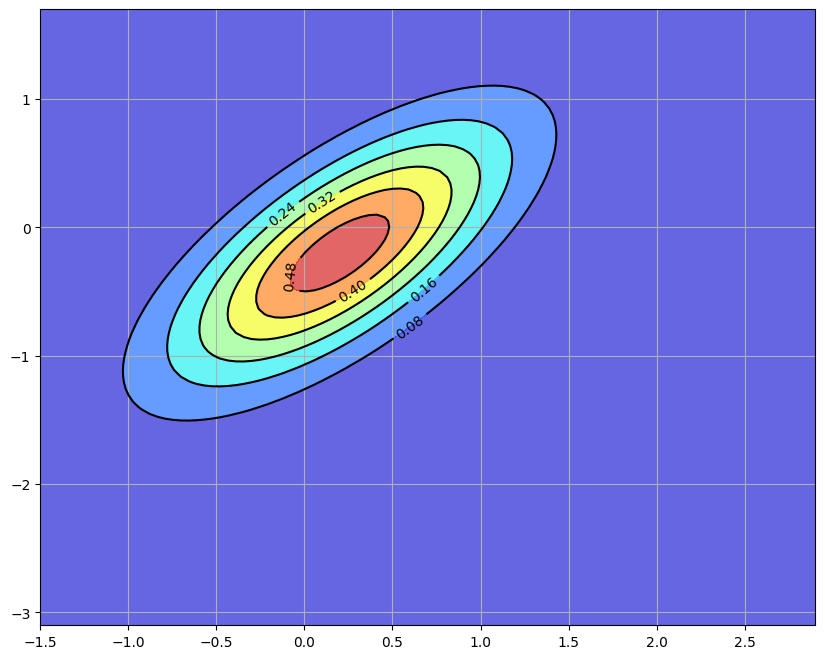

In [6]:
def gen_gaussian_plot_vals(μ, C):
    "Z values for plotting the bivariate Gaussian N(μ, C)"
    m_x, m_y = float(μ[0]), float(μ[1])
    s_x, s_y = np.sqrt(C[0, 0]), np.sqrt(C[1, 1])
    s_xy = C[0, 1]
    return bivariate_normal(X, Y, s_x, s_y, m_x, m_y, s_xy)

# Plot the figure
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

Z = gen_gaussian_plot_vals(x_hat, Σ)
ax.contourf(X, Y, Z, 6, alpha=0.6, cmap=cm.jet)
cs = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs, inline=1, fontsize=10)

plt.show()

**Explanation:**
* gen_gaussian_plot_vals() generates the probability density values for visualization.
* The plot shows the prior belief of the missile's location as a contour map.


## **The Filtering Step**

We are now presented with some good news and some bad news.

The good news is that the missile has been located by our sensors, which report that the current location is $ y = (2.3, -1.9) $.

The next figure shows the original prior $ p(x) $ and the new reported
location $ y $

<ipython-input-6-0f16c0e08e3f>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m_x, m_y = float(μ[0]), float(μ[1])
<ipython-input-8-70cfc68c4589>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.text(float(y[0]), float(y[1]), "$y$", fontsize=20, color="black")


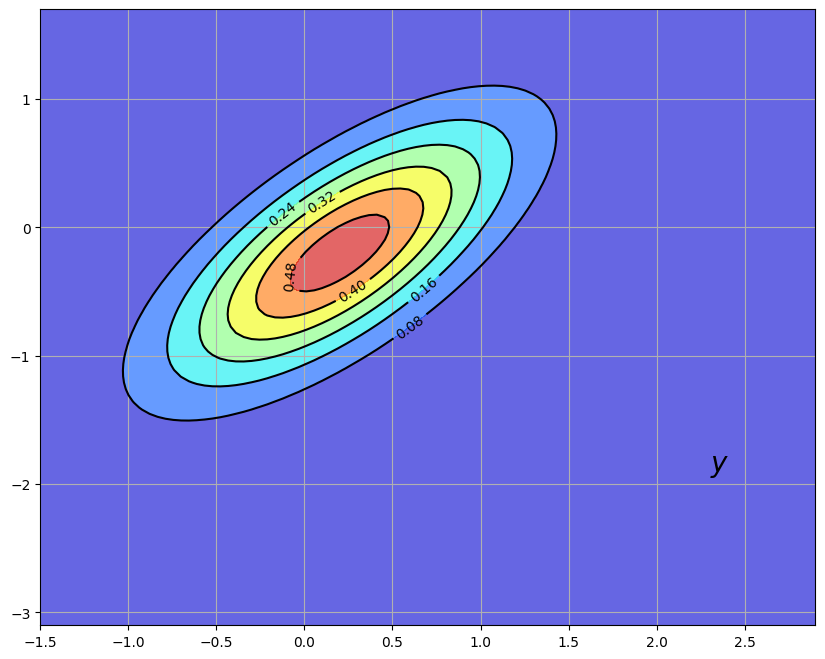

In [8]:
# Define y before using it
y = np.matrix([2.3, -1.9]).T  # As defined in the Kalman Filter section

fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

Z = gen_gaussian_plot_vals(x_hat, Σ)
ax.contourf(X, Y, Z, 6, alpha=0.6, cmap=cm.jet)
cs = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs, inline=1, fontsize=10)
ax.text(float(y[0]), float(y[1]), "$y$", fontsize=20, color="black")

plt.show()

**Explanation:**
* This block performs the Kalman filtering step, updating the estimate of the missile's location (x_hat_F) using the measurement y.
* M is the Kalman gain, which determines how much weight to give to the new measurement versus the prior estimate.
* Σ_F is the updated covariance matrix.

The bad news is that our sensors are imprecise.

In particular, we should interpret the output of our sensor not as
$ y=x $, but rather as


<a id='equation-kl-measurement-model'></a>
$$
y = G x + v, \quad \text{where} \quad v \sim N(0, R) \tag{3}
$$

Here $ G $ and $ R $ are $ 2 \times 2 $ matrices with $ R $
positive definite.  Both are assumed known, and the noise term $ v $ is assumed
to be independent of $ x $.

How then should we combine our prior $ p(x) = N(\hat x, \Sigma) $ and this
new information $ y $ to improve our understanding of the location of the
missile?

As you may have guessed, the answer is to use Bayes’ theorem, which tells
us to  update our prior $ p(x) $ to $ p(x \,|\, y) $ via

$$
p(x \,|\, y) = \frac{p(y \,|\, x) \, p(x)} {p(y)}
$$

where $ p(y) = \int p(y \,|\, x) \, p(x) dx $.

In solving for $ p(x \,|\, y) $, we observe that

- $ p(x) = N(\hat x, \Sigma) $.  
- In view of [(3)](#equation-kl-measurement-model), the conditional density $ p(y \,|\, x) $ is $ N(Gx, R) $.  
- $ p(y) $ does not depend on $ x $, and enters into the calculations only as a normalizing constant.  


Because we are in a linear and Gaussian framework, the updated density can be computed by calculating population linear regressions.

In particular, the solution is known <sup><a href=#f1 id=f1-link>[1]</a></sup> to be

$$
p(x \,|\, y) = N(\hat x^F, \Sigma^F)
$$

where


<a id='equation-kl-filter-exp'></a>
$$
\hat x^F := \hat x + \Sigma G' (G \Sigma G' + R)^{-1}(y - G \hat x)
\quad \text{and} \quad
\Sigma^F := \Sigma - \Sigma G' (G \Sigma G' + R)^{-1} G \Sigma \tag{4}
$$

Here  $ \Sigma G' (G \Sigma G' + R)^{-1} $ is the matrix of population regression coefficients of the hidden object $ x - \hat x $ on the surprise $ y - G \hat x $.

This new density $ p(x \,|\, y) = N(\hat x^F, \Sigma^F) $ is shown in the next figure via contour lines and the color map.

The original density is left in as contour lines for comparison

**The Filtering Step**

In [14]:
#M = Σ * G.T * linalg.inv(G * Σ * G.T + R)
#x_hat_F = x_hat + M * (y - G * x_hat)
#Σ_F = Σ - M * G * Σ


In [12]:
# Define the matrices G and R from the equation y = G x + N(0, R)
G = [[1, 0], [0, 1]]
G = np.matrix(G)
R = 0.5 * Σ

# Now calculate M, x_hat_F, and Σ_F using the defined G and R
M = Σ * G.T * linalg.inv(G * Σ * G.T + R)
x_hat_F = x_hat + M * (y - G * x_hat)
Σ_F = Σ - M * G * Σ

<ipython-input-6-0f16c0e08e3f>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m_x, m_y = float(μ[0]), float(μ[1])
<ipython-input-13-532500838086>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.text(float(y[0]), float(y[1]), "$y$", fontsize=20, color="black")


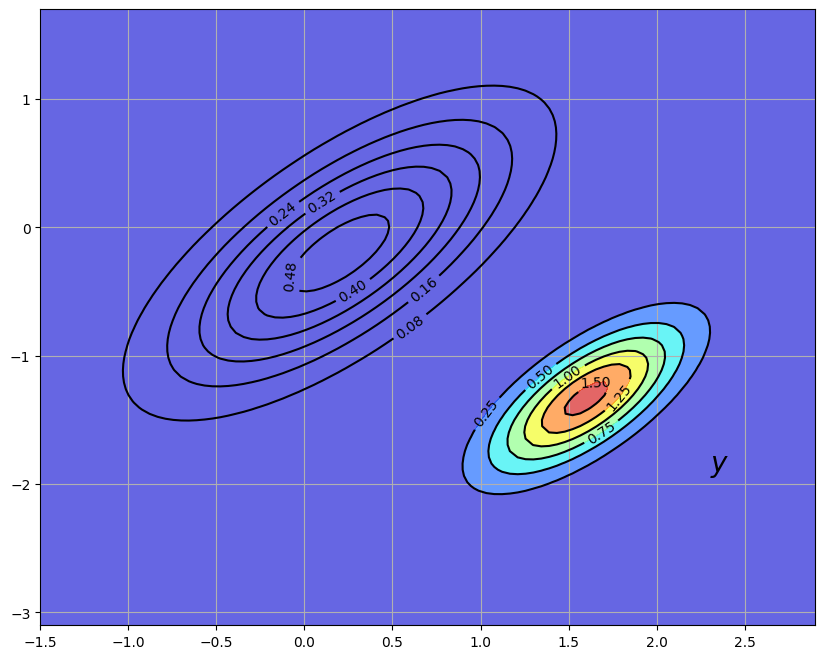

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

Z = gen_gaussian_plot_vals(x_hat, Σ)
cs1 = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs1, inline=1, fontsize=10)
M = Σ * G.T * linalg.inv(G * Σ * G.T + R)
x_hat_F = x_hat + M * (y - G * x_hat)
Σ_F = Σ - M * G * Σ
new_Z = gen_gaussian_plot_vals(x_hat_F, Σ_F)
cs2 = ax.contour(X, Y, new_Z, 6, colors="black")
ax.clabel(cs2, inline=1, fontsize=10)
ax.contourf(X, Y, new_Z, 6, alpha=0.6, cmap=cm.jet)
ax.text(float(y[0]), float(y[1]), "$y$", fontsize=20, color="black")

plt.show()

**Explanation:**
* This block performs the Kalman filtering step, updating the estimate of the missile's location (x_hat_F) using the measurement y.
* M is the Kalman gain, which determines how much weight to give to the new measurement versus the prior estimate.
* Σ_F is the updated covariance matrix.

## The Forecast Step

What have we achieved so far?

We have obtained probabilities for the current location of the state (missile) given prior and current information.

This is called “filtering” rather than forecasting because we are filtering
out noise rather than looking into the future.

- $ p(x \,|\, y) = N(\hat x^F, \Sigma^F) $ is called the *filtering distribution*  


But now let’s suppose that we are given another task: to predict the location of the missile after one unit of time (whatever that may be) has elapsed.

To do this we need a model of how the state evolves.

Let’s suppose that we have one, and that it’s linear and Gaussian. In particular,


<a id='equation-kl-xdynam'></a>
$$
x_{t+1} = A x_t + w_{t+1}, \quad \text{where} \quad w_t \sim N(0, Q) \tag{5}
$$

Our aim is to combine this law of motion and our current distribution $ p(x \,|\, y) = N(\hat x^F, \Sigma^F) $ to come up with a new *predictive* distribution for the location in one unit of time.

In view of [(5)](#equation-kl-xdynam), all we have to do is introduce a random vector $ x^F \sim N(\hat x^F, \Sigma^F) $ and work out the distribution of $ A x^F + w $ where $ w $ is independent of $ x^F $ and has distribution $ N(0, Q) $.

Since linear combinations of Gaussians are Gaussian, $ A x^F + w $ is Gaussian.

Elementary calculations and the expressions in [(4)](#equation-kl-filter-exp) tell us that

$$
\mathbb{E} [A x^F + w]
= A \mathbb{E} x^F + \mathbb{E} w
= A \hat x^F
= A \hat x + A \Sigma G' (G \Sigma G' + R)^{-1}(y - G \hat x)
$$

and

$$
\operatorname{Var} [A x^F + w]
= A \operatorname{Var}[x^F] A' + Q
= A \Sigma^F A' + Q
= A \Sigma A' - A \Sigma G' (G \Sigma G' + R)^{-1} G \Sigma A' + Q
$$

The matrix $ A \Sigma G' (G \Sigma G' + R)^{-1} $ is often written as
$ K_{\Sigma} $ and called the *Kalman gain*.

- The subscript $ \Sigma $ has been added to remind us that  $ K_{\Sigma} $ depends on $ \Sigma $, but not $ y $ or $ \hat x $.  


Using this notation, we can summarize our results as follows.

Our updated prediction is the density $ N(\hat x_{new}, \Sigma_{new}) $ where


<a id='equation-kl-mlom0'></a>
$$
\begin{aligned}
    \hat x_{new} &:= A \hat x + K_{\Sigma} (y - G \hat x) \\
    \Sigma_{new} &:= A \Sigma A' - K_{\Sigma} G \Sigma A' + Q \nonumber
\end{aligned} \tag{6}
$$

- The density $ p_{new}(x) = N(\hat x_{new}, \Sigma_{new}) $ is called the *predictive distribution*  


The predictive distribution is the new density shown in the following figure, where
the update has used parameters.

$$
A
= \left(
\begin{array}{cc}
    1.2 & 0.0 \\
    0.0 & -0.2
\end{array}
  \right),
  \qquad
Q = 0.3 * \Sigma
$$

**Forecast Step**

In [18]:
new_x_hat = A * x_hat_F
new_Σ = A * Σ_F * A.T + Q

In [16]:
# Define the matrices G and R from the equation y = G x + N(0, R)
G = [[1, 0], [0, 1]]
G = np.matrix(G)
R = 0.5 * Σ

# The matrices A and Q # This part likely belongs to a previous cell
A = [[1.2, 0], [0, -0.2]]
A = np.matrix(A)
Q = 0.1 * Σ

<ipython-input-6-0f16c0e08e3f>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m_x, m_y = float(μ[0]), float(μ[1])
<ipython-input-17-ecaf5af8f232>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.text(float(y[0]), float(y[1]), "$y$", fontsize=20, color="black")


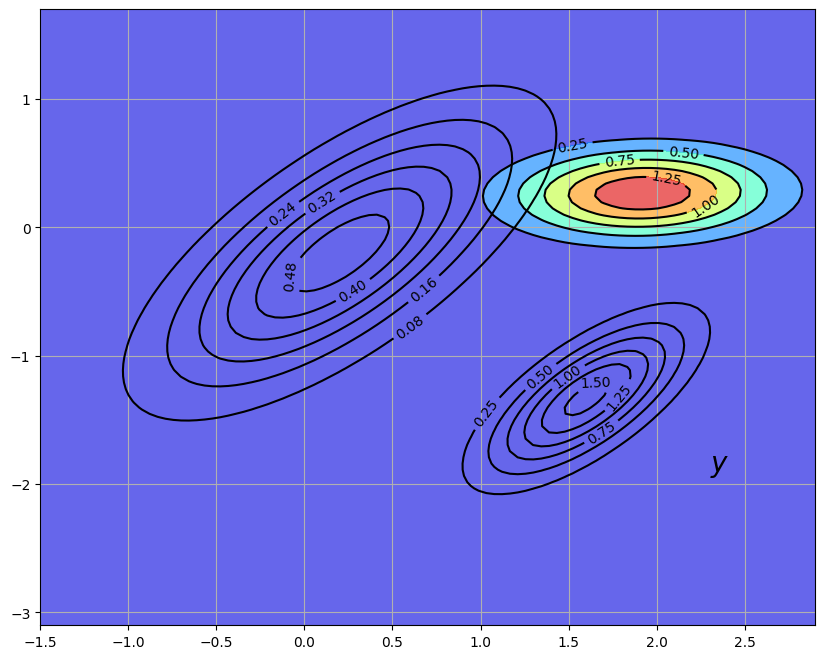

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

# Density 1
Z = gen_gaussian_plot_vals(x_hat, Σ)
cs1 = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs1, inline=1, fontsize=10)

# Density 2
M = Σ * G.T * linalg.inv(G * Σ * G.T + R)
x_hat_F = x_hat + M * (y - G * x_hat)
Σ_F = Σ - M * G * Σ
Z_F = gen_gaussian_plot_vals(x_hat_F, Σ_F)
cs2 = ax.contour(X, Y, Z_F, 6, colors="black")
ax.clabel(cs2, inline=1, fontsize=10)

# Density 3
new_x_hat = A * x_hat_F
new_Σ = A * Σ_F * A.T + Q
new_Z = gen_gaussian_plot_vals(new_x_hat, new_Σ)
cs3 = ax.contour(X, Y, new_Z, 6, colors="black")
ax.clabel(cs3, inline=1, fontsize=10)
ax.contourf(X, Y, new_Z, 6, alpha=0.6, cmap=cm.jet)
ax.text(float(y[0]), float(y[1]), "$y$", fontsize=20, color="black")

plt.show()

**Explanation:**

* This is the forecasting step, where the system predicts the next state based on the current filtered estimate.
* A models how the state evolves, and Q accounts for process noise.

Now we get another measurement with y now being at (1.8,-0.6) so we need to do another update and prediction step.

<ipython-input-6-0f16c0e08e3f>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m_x, m_y = float(μ[0]), float(μ[1])
<ipython-input-20-75f4ba737773>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.text(float(y[0]), float(y[1]), "$y$", fontsize=20, color="black")
<ipython-input-20-75f4ba737773>:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.text(float(new_y[0]), float(new_y[1]), "$y$", fontsize=20, color="red")


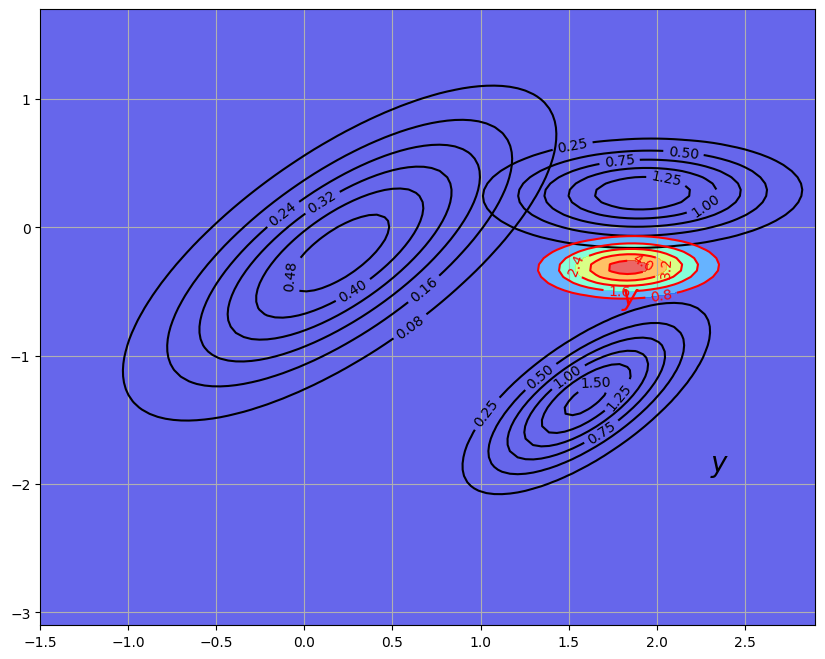

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

# Density 1
Z = gen_gaussian_plot_vals(x_hat, Σ)
cs1 = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs1, inline=1, fontsize=10)

# Density 2
M = Σ * G.T * linalg.inv(G * Σ * G.T + R)
x_hat_F = x_hat + M * (y - G * x_hat)
Σ_F = Σ - M * G * Σ
Z_F = gen_gaussian_plot_vals(x_hat_F, Σ_F)
cs2 = ax.contour(X, Y, Z_F, 6, colors="black")
ax.clabel(cs2, inline=1, fontsize=10)

# Density 3
new_x_hat = A * x_hat_F
new_Σ = A * Σ_F * A.T + Q
new_Z = gen_gaussian_plot_vals(new_x_hat, new_Σ)
cs3 = ax.contour(X, Y, new_Z, 6, colors="black")
ax.clabel(cs3, inline=1, fontsize=10)
ax.text(float(y[0]), float(y[1]), "$y$", fontsize=20, color="black")

# Density 4
M = Σ * G.T * linalg.inv(G * Σ * G.T + R)
# Define new_y before using it
new_y = np.matrix([1.8, -0.6]).T  # Updated measurement
new_x_hat_F = new_x_hat + M * (new_y - G * new_x_hat)
new_Σ_F = new_Σ - M * G * new_Σ
new_Z_F = gen_gaussian_plot_vals(new_x_hat_F, new_Σ_F)
cs4 = ax.contour(X, Y, new_Z_F, 6, colors="red")
ax.clabel(cs4, inline=1, fontsize=10)
ax.contourf(X, Y, new_Z_F, 6, alpha=0.6, cmap=cm.jet)
ax.text(float(new_y[0]), float(new_y[1]), "$y$", fontsize=20, color="red")

plt.show()

The filtered update is much closer to the new y measurement (shown in red). We just need to take account of our expected dynamics to predict where it's going next.

<ipython-input-6-0f16c0e08e3f>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m_x, m_y = float(μ[0]), float(μ[1])
<ipython-input-21-9376b06a3613>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.text(float(y[0]), float(y[1]), "$y$", fontsize=20, color="black")
<ipython-input-21-9376b06a3613>:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.text(float(new_y[0]), float(new_y[1]), "$y$", fontsize=20, color="red")


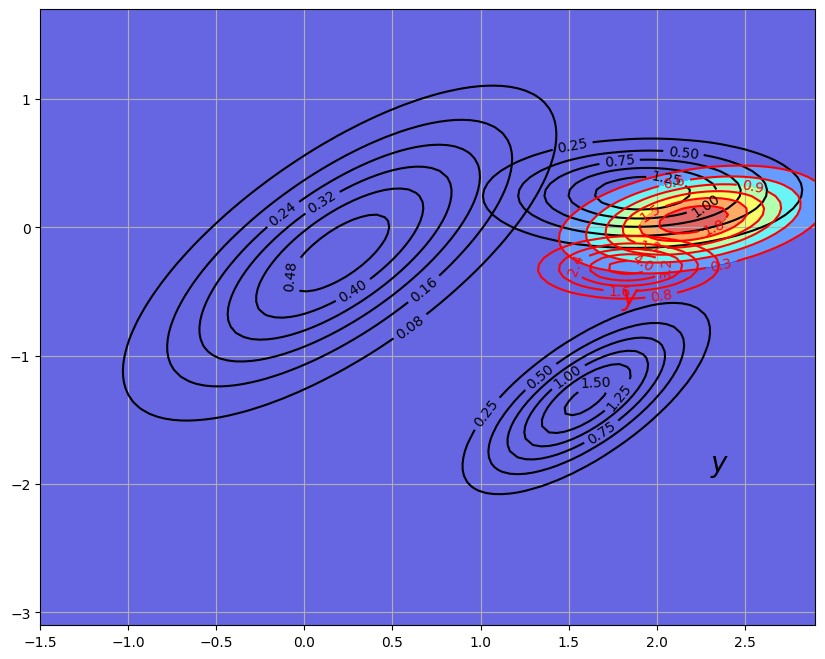

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

# Density 1
Z = gen_gaussian_plot_vals(x_hat, Σ)
cs1 = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs1, inline=1, fontsize=10)

# Density 2
M = Σ * G.T * linalg.inv(G * Σ * G.T + R)
x_hat_F = x_hat + M * (y - G * x_hat)
Σ_F = Σ - M * G * Σ
Z_F = gen_gaussian_plot_vals(x_hat_F, Σ_F)
cs2 = ax.contour(X, Y, Z_F, 6, colors="black")
ax.clabel(cs2, inline=1, fontsize=10)

# Density 3
new_x_hat = A * x_hat_F
new_Σ = A * Σ_F * A.T + Q
new_Z = gen_gaussian_plot_vals(new_x_hat, new_Σ)
cs3 = ax.contour(X, Y, new_Z, 6, colors="black")
ax.clabel(cs3, inline=1, fontsize=10)
ax.text(float(y[0]), float(y[1]), "$y$", fontsize=20, color="black")

# Density 4
M = Σ * G.T * linalg.inv(G * Σ * G.T + R)
new_x_hat_F = new_x_hat + M * (new_y - G * new_x_hat)
new_Σ_F = new_Σ - M * G * new_Σ
new_Z_F = gen_gaussian_plot_vals(new_x_hat_F, new_Σ_F)
cs4 = ax.contour(X, Y, new_Z_F, 6, colors="red")
ax.clabel(cs4, inline=1, fontsize=10)
ax.text(float(new_y[0]), float(new_y[1]), "$y$", fontsize=20, color="red")

# Density 5
new_new_x_hat = A * new_x_hat_F
new_new_Σ = A * new_Σ_F * A.T + Q
new_new_Z = gen_gaussian_plot_vals(new_new_x_hat, new_new_Σ)
cs3 = ax.contour(X, Y, new_new_Z, 6, colors="red")
ax.clabel(cs3, inline=1, fontsize=10)
ax.contourf(X, Y, new_new_Z, 6, alpha=0.6, cmap=cm.jet)

plt.show()

**Explanation:**
* This is the forecasting step, where the system predicts the next state based on the current filtered estimate.
* A models how the state evolves, and Q accounts for process noise.

# **Fourier Analysis**

In Fouries Analysis, we transform a time domain representation (function of time) to a frequency domain representation (function of frequency) to analyse the characteristics in data such as periodicity.

Tutorials:
* [Fourier Transforms (scipy.fft)](https://docs.scipy.org/doc/scipy/tutorial/fft.html)
* [Python Operators](https://www.w3schools.com/python/python_operators.asp)

In [25]:
# Define a sample time series
N = 200 # number of sample points
T = 1.0 / 800.0 # sample spacing
x = np.linspace(0.0, N*T, N)
print(x.shape)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x) + 0.5*np.random.normal(size=(N))
print(y.shape)

(200,)
(200,)


**Explanation**: Generate a sample time series with two sinusoidal components and random noise.

**Plot the Time Series**

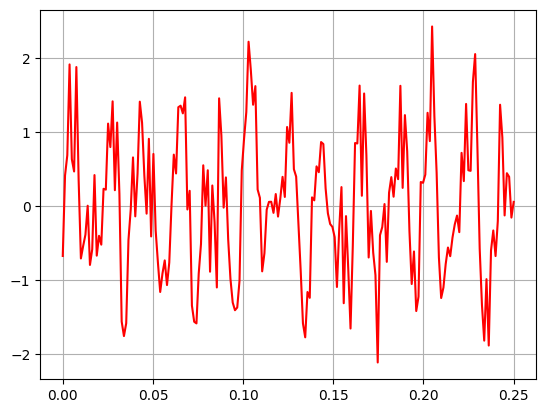

In [26]:
# plot series
plt.plot(x,y,'r')
plt.grid()
plt.show()

**Explanation:** Visualize the generated time series.

**Perform Fourier Transform**

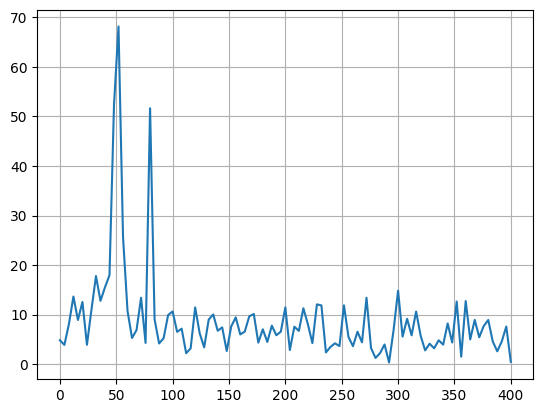

In [27]:
# Fourier transform
yf   = rfft(y)
xf   = rfftfreq(N,T)

# plot series
plt.plot(xf,np.abs(yf))
plt.grid()
plt.show()

**Explanation:**
* The Fourier transform converts the time series into the frequency domain.
* The plot shows the frequency components present in the data.

**Remove Noise and Inverse Transform**

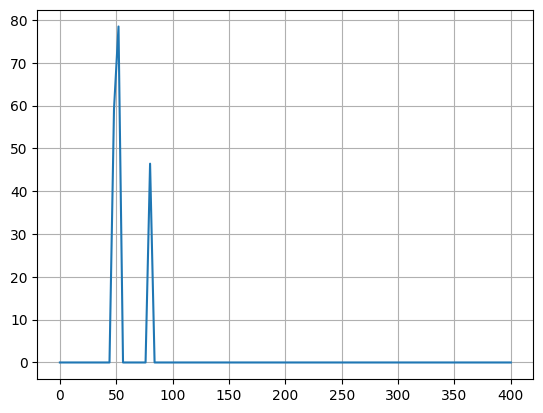

In [24]:
# remove noise frequencies
yf_abs      = np.abs(yf)
indices     = yf_abs>30   # filter out those values under 30
yf_clean    = indices * yf # noise frequency will be set to 0

# plot series
plt.plot(xf,np.abs(yf_clean))
plt.grid()
plt.show()

**Explanation:**
* Noise frequencies are removed by filtering out low-amplitude components.
* The inverse Fourier transform reconstructs the time series from the cleaned frequency spectrum.

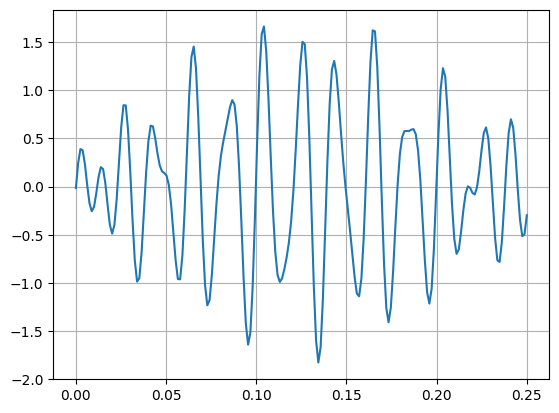

In [28]:
# inverse back to time domain
y_clean = irfft(yf_clean)

# plot series
plt.plot(x,y_clean)
plt.grid()
plt.show()

# Independent Component Analysis

Tutorial - [Independent Component Analysis (ICA) In Python](https://towardsdatascience.com/independent-component-analysis-ica-in-python-a0ef0db0955e)

# Changepoints

Tutorial - [Detecting the Change Points in a Time Series](https://medium.com/dataman-in-ai/finding-the-change-points-in-a-time-series-95a308207012)

**Summary**

* We implemented Kalman filtering, where we estimated and updated the position of a target using noisy measurements.
* We performed Fourier analysis to extract and clean frequency components from a noisy time series.
* The exercises demonstrated important time series techniques, including filtering, forecasting, and signal processing.

**Import Libraries**

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import linalg
from scipy.fft import rfft, rfftfreq, irfft


**Explanation:**

* We import essential libraries:
* numpy: For numerical operations and matrix manipulation.
* matplotlib: For visualizations (plots, contours).
* scipy.linalg: For advanced linear algebra functions like matrix inversions.
* scipy.fft: For Fourier analysis functions (rfft for fast Fourier transform).

**Kalman Filter Explanation**

The Kalman filter is a recursive estimation algorithm designed to filter noisy data and predict future states in dynamic systems.

* **Prior (p(x)):** Initial knowledge about the object's position, modeled as a Gaussian distribution.
* **Observation (y):** The current noisy measurement of the object's position.
* **Update:** The prior is updated based on the new observation to get a more accurate position estimate.
* **Prediction:** The updated position is forecasted forward in time, accounting for system dynamics and process noise.

**Define Prior (Initial Belief)**

In [30]:
Σ = [[0.4, 0.3], [0.3, 0.45]]  # Initial covariance matrix
Σ = np.matrix(Σ)
x_hat = np.matrix([0.2, -0.2]).T  # Initial position estimate


**Explanation:**
* Σ: The covariance matrix represents uncertainty in our estimate.
* x_hat: Initial state vector (missile's position) expressed in 2D coordinates.

**Measurement and System Models**

In [31]:
G = [[1, 0], [0, 1]]  # Observation matrix
G = np.matrix(G)
R = 0.5 * Σ            # Measurement noise covariance
A = [[1.2, 0], [0, -0.2]]  # State transition matrix
A = np.matrix(A)
Q = 0.1 * Σ            # Process noise covariance
y = np.matrix([2.3, -1.9]).T  # Observation (current position)
new_y = np.matrix([1.8, -0.6]).T  # Next observation


**Explanation:**
* G: Describes how measurements relate to the true state (identity matrix here).
* R: Models uncertainty/noise in the observation (y).
* A: State transition matrix, modeling how the object's state changes over time.
* Q: Process noise—uncertainty in system dynamics.

**Grid Setup for Plotting**

In [32]:
x_grid = np.linspace(-1.5, 2.9, 100)
y_grid = np.linspace(-3.1, 1.7, 100)
X, Y = np.meshgrid(x_grid, y_grid)


**Explanation:**

* We define a grid of points to visualize the Gaussian probability distribution.

**Define Bivariate Gaussian Distribution**

In [33]:
def bivariate_normal(x, y, σ_x=1.0, σ_y=1.0, μ_x=0.0, μ_y=0.0, σ_xy=0.0):
    x_μ = x - μ_x
    y_μ = y - μ_y
    ρ = σ_xy / (σ_x * σ_y)
    z = x_μ**2 / σ_x**2 + y_μ**2 / σ_y**2 - 2 * ρ * x_μ * y_μ / (σ_x * σ_y)
    denom = 2 * np.pi * σ_x * σ_y * np.sqrt(1 - ρ**2)
    return np.exp(-z / (2 * (1 - ρ**2))) / denom


**Explanation:**
* This function returns the probability density for a bivariate Gaussian at points (x, y).

**Plot the Prior Distribution**

<ipython-input-34-4dbfeee2e18f>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m_x, m_y = float(μ[0]), float(μ[1])


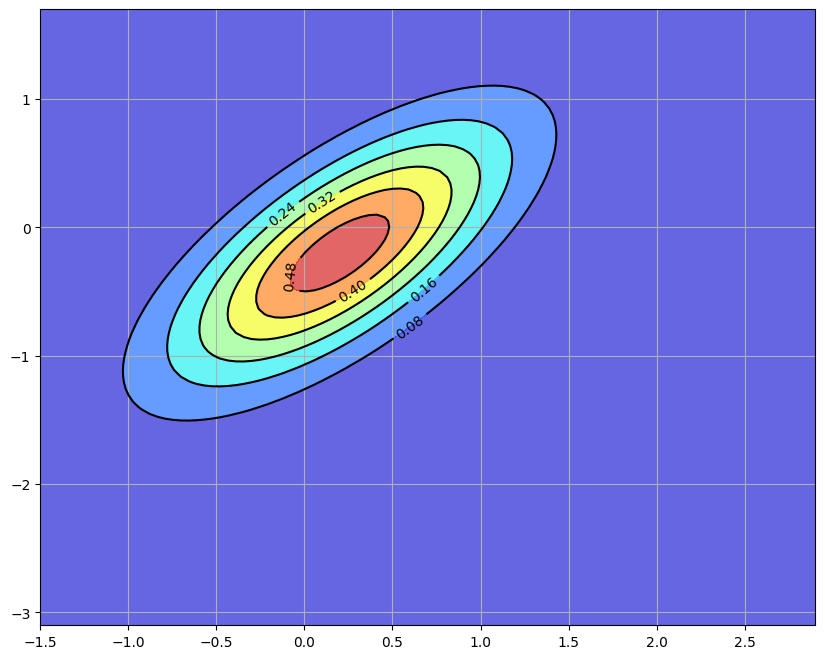

In [34]:
def gen_gaussian_plot_vals(μ, C):
    m_x, m_y = float(μ[0]), float(μ[1])
    s_x, s_y = np.sqrt(C[0, 0]), np.sqrt(C[1, 1])
    s_xy = C[0, 1]
    return bivariate_normal(X, Y, s_x, s_y, m_x, m_y, s_xy)

fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()
Z = gen_gaussian_plot_vals(x_hat, Σ)
ax.contourf(X, Y, Z, 6, alpha=0.6, cmap=cm.jet)
cs = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs, inline=1, fontsize=10)
plt.show()


**Explanation:**
* We visualize the prior belief (p(x)) as a contour map.

**Filtering Step: Update the State Estimate**

In [35]:
M = Σ * G.T * linalg.inv(G * Σ * G.T + R)  # Kalman gain
x_hat_F = x_hat + M * (y - G * x_hat)      # Updated estimate
Σ_F = Σ - M * G * Σ                        # Updated covariance


**Explanation:**
* The Kalman gain (M) balances the contribution of the new measurement versus the prior estimate.
* x_hat_F: The new position estimate after incorporating the measurement.
* Σ_F: The updated uncertainty after filtering.

**Forecasting Step**

In [36]:
new_x_hat = A * x_hat_F           # Forecasted state
new_Σ = A * Σ_F * A.T + Q         # Forecasted covariance


**Explanation:**
* We predict the next state using the system dynamics (A) and process noise (Q).

## **Fourier Analysis**

**Generate Sample Time Series**

In [37]:
N = 200  # Number of data points
T = 1.0 / 800.0  # Sampling interval
x = np.linspace(0.0, N*T, N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x) + 0.5*np.random.normal(size=(N))


**Explanation:**
* We create a synthetic time series with two sinusoidal components and added noise.

**Plot the Time Series**

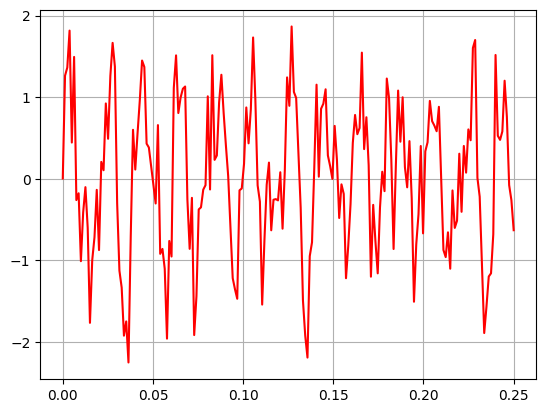

In [38]:
plt.plot(x, y, 'r')
plt.grid()
plt.show()


**Explanation:** We visualize the noisy time series.

**Fourier Transform**

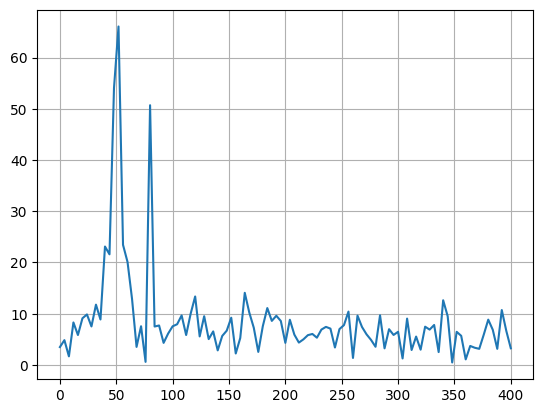

In [39]:
yf = rfft(y)
xf = rfftfreq(N, T)
plt.plot(xf, np.abs(yf))
plt.grid()
plt.show()


**Explanation:**
* We apply the Fourier transform to convert the time series to the frequency domain.
* The plot shows the frequency components.


**Noise Removal**

In [40]:
yf_abs = np.abs(yf)
indices = yf_abs > 30  # Filter low-amplitude components
yf_clean = indices * yf


**Explanation:**
* We filter out noise by removing frequencies with low amplitudes.

**Inverse Fourier Transform**

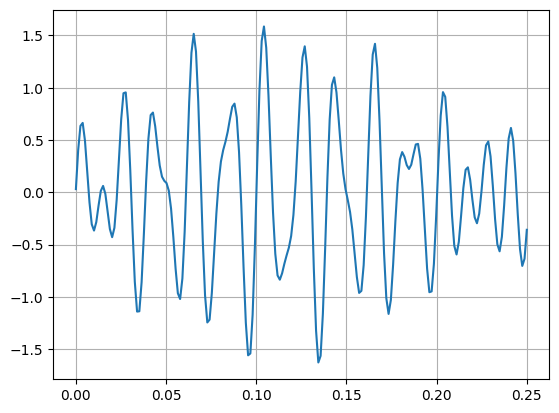

In [41]:
y_clean = irfft(yf_clean)
plt.plot(x, y_clean)
plt.grid()
plt.show()


**Explanation:**
* We reconstruct the cleaned time series using the inverse Fourier transform.

**Exercise Summary**

1. Kalman Filtering:

  * We implemented the Kalman filter, showing how noisy measurements can be filtered to estimate a dynamic system's state.
2. Fourier Analysis:

  * We performed Fourier transformation to analyze the frequency components of a time series, removed noise, and reconstructed a clean signal.

**Step-by-Step Explanation of the Exercise Summary**

**Part 1: Kalman Filtering**

**Goal:**
To filter noisy data, update our knowledge of the object's state, and forecast the next state using the Kalman filter.

**Step 1: Define Initial Belief (Prior)**

* We assume that the object's position follows a Gaussian distribution.
* The initial belief (p(x)) has a mean and covariance matrix:


In [46]:
Σ = [[0.4, 0.3], [0.3, 0.45]]
Σ = np.matrix(Σ)  # Convert Σ to a NumPy matrix
x_hat = np.matrix([0.2, -0.2]).T


**Step 2: Set Up Measurement and System Models**
* Define matrices for the measurement model (G and R) and system dynamics (A and Q):



In [47]:
G = [[1, 0], [0, 1]]   # Observation model
R = 0.5 * Σ            # Measurement noise covariance
A = [[1.2, 0], [0, -0.2]]  # State transition model
Q = 0.1 * Σ            # Process noise covariance


**Step 3: Plot Initial Belief**
* We visualize the prior distribution using contour plots:

In [48]:
Z = gen_gaussian_plot_vals(x_hat, Σ)
ax.contourf(X, Y, Z, 6, alpha=0.6, cmap=cm.jet)


<ipython-input-34-4dbfeee2e18f>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m_x, m_y = float(μ[0]), float(μ[1])


**Step 4: Receive Observation**
* We simulate receiving a noisy observation:

In [49]:
y = np.matrix([2.3, -1.9]).T


**Step 5: Apply the Kalman Filter**
* **Update Step:**
  * Calculate the Kalman gain (M), which adjusts how much we trust the new observation versus the prior:

In [51]:
# Convert G to a NumPy matrix before using .T
G = np.matrix(G)


M = Σ * G.T * linalg.inv(G * Σ * G.T + R)


* **Update the position estimate (x_hat_F) and uncertainty (Σ_F):**


In [52]:
x_hat_F = x_hat + M * (y - G * x_hat)
Σ_F = Σ - M * G * Σ


**Step 6: Predict the Next State**
* Forecast the next position using the state transition model (A):

In [54]:
# Convert A to a NumPy matrix
A = np.matrix(A)
new_x_hat = A * x_hat_F
new_Σ = A * Σ_F * A.T + Q


* Visualize the updated and predicted distributions.

**Step 7: Repeat the Process**
* With a new observation (new_y), repeat the update and prediction steps:

In [55]:
new_y = np.matrix([1.8, -0.6]).T
new_y

matrix([[ 1.8],
        [-0.6]])

**Part 2: Fourier Analysis**

**Goal:**
To analyze the frequency components of a time series, filter out noise, and reconstruct a clean signal.



**Step 1: Generate a Sample Time Series**

* Create a time series with two sinusoidal components and added noise:

In [56]:
N = 200              # Number of data points
T = 1.0 / 800.0      # Sampling interval
x = np.linspace(0.0, N*T, N)  # Time values
y = np.sin(50.0 * 2.0 * np.pi * x) + 0.5 * np.sin(80.0 * 2.0 * np.pi * x) + 0.5 * np.random.normal(size=(N))


**Step 2: Apply Fourier Transform**
* Convert the time series from the time domain to the frequency domain:

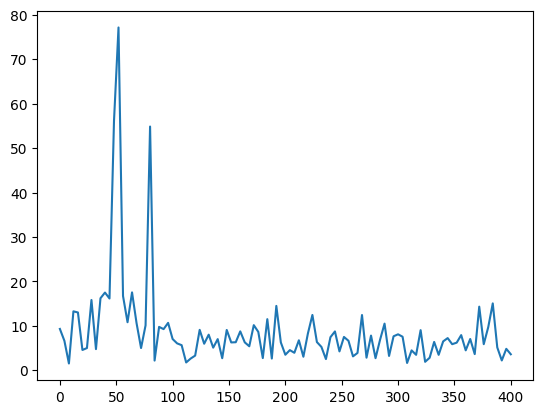

In [57]:
yf = rfft(y)          # Fast Fourier Transform
xf = rfftfreq(N, T)   # Frequency values
plt.plot(xf, np.abs(yf))  # Plot frequency spectrum


**Step 3: Remove Noise**
* Identify and filter out low-amplitude frequency components (noise):

In [58]:
yf_abs = np.abs(yf)
indices = yf_abs > 30      # Keep only significant frequencies
yf_clean = indices * yf    # Set noise frequencies to zero


**Step 4: Inverse Fourier Transform**
* Convert the filtered signal back to the time domain:


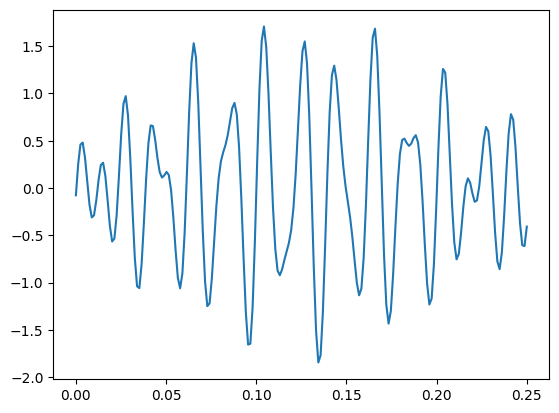

In [59]:
y_clean = irfft(yf_clean)
plt.plot(x, y_clean)  # Plot the cleaned time series


**Step 5: Compare the Results**
* Compare the original noisy time series with the cleaned version to verify noise removal.


**Summary**
* Kalman Filtering: We demonstrated how noisy data can be recursively filtered and predicted using the Kalman filter.
* Fourier Analysis: We showed how to analyze and clean a time series by transforming it to the frequency domain and removing noise.